## load modules and configure

In [1]:
import sys
from pathlib import Path
from importlib import reload

In [2]:
project_path = str(Path.home()/'gd'/'projects')

sys.path.insert(0, project_path + '/ftnmr/scripts')
sys.path.insert(0, project_path + '/projnmr/scripts')
sys.path.insert(0, project_path + '/handson/scripts/part2')
sys.path.insert(0, project_path + '/mods/scripts')

In [3]:
import ftnmr
import projnmr
import handson
import mods

In [39]:
import inspect
import random
from functools import partial
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tqdm import tqdm

In [5]:
import os
# for error "not creating xla devices tf_xla_enable_xla_devices not set"
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#TF_XLA_FLAGS is an environment variable used by TensorFlow's XLA (Accelerated Linear Algebra) 
#compiler to control its behavior. In this case, setting TF_XLA_FLAGS to 
#--tf_xla_enable_xla_devices enables the XLA compiler to use all available XLA devices, 
#such as GPUs or TPUs, for faster execution of TensorFlow computations.

# for error "Successfully opened dynamic library libcudart.so.10.1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
# similar to os.environ['TF_XLA_FLAGS'], but preferred way to enable XLA
tf.config.optimizer.set_jit(True) 

tf.__version__ # TF version

'2.11.1'

In [7]:
devices = tf.config.get_visible_devices()
for dev in devices:
    print(dev.name)

/physical_device:CPU:0
/physical_device:XLA_CPU:0
/physical_device:GPU:0
/physical_device:XLA_GPU:0


In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
import pynvml
pynvml.nvmlInit()

gpus = pynvml.nvmlDeviceGetCount()
for i in range(gpus):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU {i}: Total memory: {info.total / (1024**2)} MB")
    print(f"       Free memory: {info.free / (1024**2)} MB")

pynvml.nvmlShutdown()

GPU 0: Total memory: 32768.0 MB
       Free memory: 32497.375 MB


## fully connected model with flatten input layer

In [10]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.mnist_data()

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # add flatten layer to the model first
model.add(keras.layers.Dense(300, activation="relu")) # add dense layer with 300 neurons second
model.add(keras.layers.Dense(100, activation="relu")) # third
model.add(keras.layers.Dense(10, activation="softmax")) # last, which is output layer

In [12]:
# same as above
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")])

In [13]:
# In Keras, compile() is a method used to configure the learning process of a model. 
# This method defines the loss function, optimizer, and metrics for training
model.compile(
    loss="sparse_categorical_crossentropy", # sparse when categories are in integers
    optimizer="sgd", # Stochastic Gradient Descent
    metrics=["accuracy"]) # performance metrics for each epoch on validataion dataset

# An optimizer is an gradient descent method algorithm to update the weights and biases
model.optimizer.get_config() # default mini batch size for SGD is 32 in keras model

{'name': 'SGD',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': 0.01,
 'momentum': 0.0,
 'nesterov': False}

In [14]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_valid, y_valid)) # fit method initiates training

Epoch 1/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7192 - accuracy: 0.7661 - val_loss: 0.5073 - val_accuracy: 0.8338
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4900 - accuracy: 0.8295 - val_loss: 0.4574 - val_accuracy: 0.8430
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4446 - accuracy: 0.8453 - val_loss: 0.4217 - val_accuracy: 0.8572
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4177 - accuracy: 0.8527 - val_loss: 0.3932 - val_accuracy: 0.8634
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3976 - accuracy: 0.8601 - val_loss: 0.3940 - val_accuracy: 0.8612
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3805 - accuracy: 0.8664 - val_loss: 0.3911 - val_accuracy: 0.8618
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3661 - accuracy: 0.8708 - val_loss: 0.3672 - val_accuracy:

## basic keras layers

In [397]:
# list of laysers in keras (ignore Layer method below)
layers = mods.list_attr('layers')

# randomly select a layer name
rand_layer = random.choice(layers) # randomly select an layer name

# layer class with the above layer name with 300 neurons
rand_layer = getattr(keras.layers, rand_layer)
display(rand_layer)

# get the name of the chosen layer 
layer_name = rand_layer.__name__
print(layer_name)

AbstractRNNCell          Activation               ActivityRegularization   Add                      AdditiveAttention        AlphaDropout             Attention                Average                  AveragePooling1D         AveragePooling2D         AveragePooling3D         AvgPool1D                AvgPool2D                AvgPool3D                BatchNormalization       Bidirectional            CategoryEncoding         CenterCrop               Concatenate              Conv1D                   Conv1DTranspose          Conv2D                   Conv2DTranspose          Conv3D                   Conv3DTranspose          ConvLSTM1D               ConvLSTM2D               ConvLSTM3D               Convolution1D            Convolution1DTranspose   Convolution2D            Convolution2DTranspose   Convolution3D            Convolution3DTranspose   Cropping1D               Cropping2D               Cropping3D               Dense                    DenseFeatures            DepthwiseConv1D          

keras.layers.pooling.average_pooling3d.AveragePooling3D

AveragePooling3D


## basic keras layer parameters

In [10]:
# units: This specifies the number of neurons in the layer
# use_bias: This specifies whether to include a bias term in the layer (default True) 

In [65]:
# activation: This specifies the activation function to be used in the layer.

# the below code lists activation functions (ignore deserialize, get, and serialize methods)
activations = []
for act in dir(keras.activations):
    if not act.startswith('_') and act not in ['deserialize', 'get', 'serialize']:
        activations.append(act)
        print(act.ljust(20), end='')

# randomly select an activation function name
rand_act = random.choice(activations) 

# dense layer instantiation with the above activation name with 300 neurons
dense_layer = keras.layers.Dense(units=300, activation=rand_act)
display(dense_layer.activation)

# get the name of the activation function from the above layer 
act_name = dense_layer.activation.__name__
print(act_name)

elu                 exponential         gelu                hard_sigmoid        linear              relu                selu                sigmoid             softmax             softplus            softsign            swish               tanh                

<function keras.activations.linear(x)>

linear


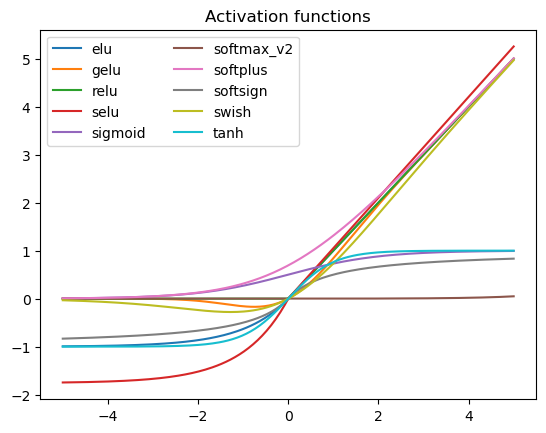

In [66]:
# plot all activation functions on one figure
# Define the x values
x = tf.linspace(-5., 5., 200)

# Define the activation functions with out exponential
activation_functions = [
    tf.nn.elu, 
    tf.nn.gelu, 
    tf.nn.relu, 
    tf.nn.selu, 
    tf.nn.sigmoid, 
    tf.nn.softmax, 
    tf.nn.softplus, 
    tf.nn.softsign, 
    tf.nn.swish, 
    tf.nn.tanh]

# Plot the activation functions
for activation in activation_functions[:]: # select the ones you want to plot
    with tf.compat.v1.Session().as_default():
        plt.plot(x, activation(tf.constant(x)).numpy(), label=activation.__name__)

# Add title and legend
plt.title('Activation functions')
plt.legend(loc='best', ncol=2)
plt.show()

In [137]:
# kernel_initializer: This specifies the method for initializing the weights of the layer
# bias_initializer is for biases

# list of kernel initializers in keras (ignore Initializer method below)
initializers = handson.list_attr('initializers')

# randomly select an kernel initializer name
rand_init = random.choice(initializers) 

# dense layer instantiation with the above kernel initializer name with 300 neurons
dense_layer = keras.layers.Dense(units=300, kernel_initializer=rand_init)
display(dense_layer.kernel_initializer)

# get the name of the kernel initializer from the above layer 
init_name = dense_layer.kernel_initializer.__class__.__name__
print(init_name)

Constant                 GlorotNormal             GlorotUniform            HeNormal                 HeUniform                Identity                 Initializer              LecunNormal              LecunUniform             Ones                     Orthogonal               RandomNormal             RandomUniform            TruncatedNormal          VarianceScaling          Zeros                    

Constant


In [138]:
# kernel_regularizer: This specifies the regularization method to be applied to the weights 
# of the layer. bias_regularizer is for biases

# list of kernel regularizers in keras (ignore Regularizer method below)
kernel_regularizer = handson.list_attr('regularizers')
# randomly select a kernel regularizer name
rand_reg = random.choice(kernel_regularizer) 

# dense layer instantiation with the above kernel regularizer name with 300 neurons
dense_layer = keras.layers.Dense(units=300, kernel_regularizer=rand_reg)
display(dense_layer.kernel_regularizer)

# get the name of the kernel regularizer from the above layer 
reg_name = dense_layer.kernel_regularizer.__class__.__name__
print(reg_name)

# activity_regularizer: regularization method applied to the output of the layer
# same regularizers from kernel regularizations can be used

L1                       L1L2                     L2                       OrthogonalRegularizer    Regularizer              

L1


In [139]:
# kernel_constraint: This specifies the constraint to be applied to the weights of the layer.
# bias_constraint is for biases
# kernel constraints enforce constraints directly on the weights of the neural network.
# whereas kernel regularizers add a penalty term to the loss function 

# list of kernel constraints in keras (ignore Constraint method below)
kernel_constraints = handson.list_attr('constraints')

# randomly select a kernel constraints name
rand_con = random.choice(kernel_constraints) 

# dense layer instantiation with the above kernel regularizer name with 300 neurons
dense_layer = keras.layers.Dense(units=300, kernel_constraint=rand_con)
display(dense_layer.kernel_constraint)

# get the name of the kernel regularizer from the above layer 
con_name = dense_layer.kernel_constraint.__class__.__name__
print(con_name)

Constraint               MaxNorm                  MinMaxNorm               NonNeg                   RadialConstraint         UnitNorm                 

RadialConstraint


## loss functions and metrics

In [153]:
# loss: This specifies the loss function (or cost function) to be used in the layer.

# the below code lists loss functions (ignore deserialize, get, and serialize methods)
losses = []
for loss in dir(keras.losses):
    if not loss.startswith('_') and loss not in ['deserialize', 'get', 'serialize']:
        losses.append(loss)
        print(loss.ljust(60), end='')

# randomly select an loss function name
rand_loss = random.choice(losses) # randomly select an activation function name
print()
print(rand_loss)

# load pretrained VGG16 model
model = keras.applications.VGG16(weights='imagenet', include_top=True)

# compile the model with the randomly chosen loss function
model.compile(loss=rand_loss)
model.loss

BinaryCrossentropy                                          BinaryFocalCrossentropy                                     CategoricalCrossentropy                                     CategoricalHinge                                            CosineSimilarity                                            Hinge                                                       Huber                                                       KLD                                                         KLDivergence                                                LogCosh                                                     Loss                                                        MAE                                                         MAPE                                                        MSE                                                         MSLE                                                        MeanAbsoluteError                                           MeanAbsolutePercentageError             

'huber'

In [154]:
# list of metrics in keras (ignore Metric method below)
metrics = handson.list_attr('metrics', 50)
print()

# randomly select a metric name
rand_metric = random.choice(metrics) # randomly select an activation function name

# load pretrained VGG16 model
model = keras.applications.VGG16(weights='imagenet', include_top=True)

# compile the model with the randomly chosen metric
model.compile(metrics=[rand_metric])

print(rand_metric)
model.metrics # it will return an empty list since the model is never trained

AUC                                               Accuracy                                          BinaryAccuracy                                    BinaryCrossentropy                                BinaryIoU                                         CategoricalAccuracy                               CategoricalCrossentropy                           CategoricalHinge                                  CosineSimilarity                                  FalseNegatives                                    FalsePositives                                    Hinge                                             IoU                                               KLDivergence                                      LogCoshError                                      Mean                                              MeanAbsoluteError                                 MeanAbsolutePercentageError                       MeanIoU                                           MeanMetricWrapper                                 

[]

## model history and evaluation (previous model training needed)

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])



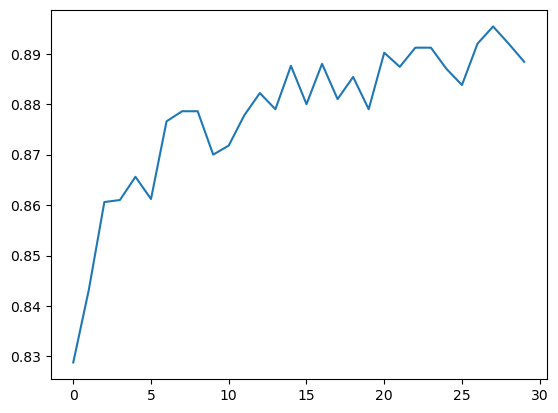

In [25]:
print(history.history.keys(), end='\n\n')
val_accuracy = history.history['val_accuracy']

plt.plot(range(len(val_accuracy)), val_accuracy)
plt.show()

In [26]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 992us/step - loss: 60.1161 - accuracy: 0.8503


[60.116050720214844, 0.8503000140190125]

## simple sequential model

In [19]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.housing_data()

In [45]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)])

model.compile(loss="mean_squared_error", optimizer="sgd")

In [30]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.8334 - val_loss: 0.6144
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5087 - val_loss: 0.4973
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4531 - val_loss: 0.4847
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.9033 - val_loss: 0.5254
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 1.7038 - val_loss: 0.4664
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5945 - val_loss: 0.4346
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3837 - val_loss: 0.4142
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3801 - val_loss: 0.4094
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3737 - val_loss: 0.4020
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3689 - val_loss: 0.3954

In [31]:
mse_test

0.353873074054718

## model with hidden concatenate layer

In [20]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.housing_data()

In [38]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

In [39]:
# it does not work well
model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.7307 - val_loss: 3.7913
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 11/20
363/363 [==============================] 

## two inputs model with concatenate layer

In [21]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.housing_data()

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

In [41]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

In [42]:
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

In [44]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3)) 
model.optimizer.get_config()

{'name': 'SGD',
 'learning_rate': 0.001,
 'decay': 0.0,
 'momentum': 0.0,
 'nesterov': False}

In [45]:
history = model.fit(
    (X_train_A, X_train_B), 
    y_train, 
    epochs=20,
    validation_data=((X_valid_A, X_valid_B),y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.2099 - val_loss: 0.9340
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8194 - val_loss: 0.7372
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7093 - val_loss: 0.6811
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6663 - val_loss: 0.6494
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6383 - val_loss: 0.6266
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6161 - val_loss: 0.6059
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5967 - val_loss: 0.5857
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5796 - val_loss: 0.5707
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5657 - val_loss: 0.5546
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5515 - val_loss: 0.5409

In [46]:
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
mse_test

162/162 [==============================] - 0s 865us/step - loss: 0.4868


0.486760675907135

## two inputs and two outputs model

In [22]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.housing_data()

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

In [50]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

In [51]:
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [52]:
# the first output is more important, so more weight is assigned on it for loss function
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd")

In [53]:
history = model.fit(
    [X_train_A, X_train_B], 
    [y_train, y_train], 
    epochs=20,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9012 - main_output_loss: 0.7970 - aux_output_loss: 1.8398 - val_loss: 1.0476 - val_main_output_loss: 1.0383 - val_aux_output_loss: 1.1313
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6920 - main_output_loss: 0.6541 - aux_output_loss: 1.0333 - val_loss: 0.6091 - val_main_output_loss: 0.5581 - val_aux_output_loss: 1.0682
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5399 - main_output_loss: 0.4935 - aux_output_loss: 0.9581 - val_loss: 0.6482 - val_main_output_loss: 0.6223 - val_aux_output_loss: 0.8817
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5700 - main_output_loss: 0.5435 - aux_output_loss: 0.8091 - val_loss: 0.5049 - val_main_output_loss: 0.4736 - val_aux_output_loss: 0.7862
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4771 - main_output_loss: 0.4484 - aux_output_loss: 0.7354 - val_loss

In [54]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
print(total_loss, main_loss, aux_loss)

162/162 [==============================] - 0s 1ms/step - loss: 0.3910 - main_output_loss: 0.3742 - aux_output_loss: 0.5421
0.39098742604255676 0.37419408559799194 0.5421300530433655


## checkpoint

In [23]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.housing_data()

In [61]:
# ModelCheckpoint is a callback function in Keras that saves the model weights during training. 
# It allows you to save the best model observed during training based on a specified metric, 
# such as validation loss or accuracy.

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.hdf5", save_best_only=True)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)])

model.compile(loss="mean_squared_error", optimizer="sgd")

In [57]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    validation_data=(X_valid, y_valid), 
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 2.0102 - val_loss: 1.0858
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6909 - val_loss: 0.4760
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4236 - val_loss: 0.4251
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.3943 - val_loss: 0.4208
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.3893 - val_loss: 0.3999
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.3744 - val_loss: 0.4053
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.3727 - val_loss: 0.3985
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.3695 - val_loss: 0.4004
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.3739 - val_loss: 0.4031
Epoch 10/10
363/363 [==============================] - 0s 1ms/step - loss: 0.3646 - val_loss: 0.4025

In [60]:
model = keras.models.load_model("my_keras_model.hdf5") # roll back to best model

## early stopping

In [24]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.housing_data()

In [505]:
# EarlyStopping is a callback in Keras that can be used during training to automatically stop 
# training when a monitored metric stops improving. It is designed to prevent overfitting and 
# reduce training time by stopping the training process early when further training is unlikely
# to improve the model's performance.

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# In early stopping, "patience" is a hyperparameter that determines the number of epochs 
# the model can undergo without improvement in the monitored quantity before stopping the 
# training process. 

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)])

model.compile(loss="mean_squared_error", optimizer="sgd")

In [506]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 1.2088 - val_loss: 7.5077
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.7584 - val_loss: 0.5632
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4886 - val_loss: 0.4733
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4470 - val_loss: 0.4236
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4289 - val_loss: 0.4147
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4303 - val_loss: 0.4266
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4329 - val_loss: 0.4127
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4121 - val_loss: 0.4273
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4070 - val_loss: 0.4150
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4021 - val_lo

In [507]:
mse_test = model.evaluate(X_test, y_test)
mse_test

162/162 [==============================] - 0s 764us/step - loss: 0.3466


0.34658145904541016

## model with batch normalization layers and kernal initialization

In [25]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.housing_data()

In [73]:
# batch normalization normalizes intermediate vectors between layers. The benefits are:
# 1. Improved training speed 
# 2. Better generalization
# 3. Less sensitivity to weight initialization
# 4. High tolerance on higher learning rates
# 5. Regularization

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(15, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)])

In [69]:
model.compile(loss="mean_squared_error", optimizer="sgd")

In [70]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6945 - val_loss: 0.6429
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4921 - val_loss: 0.8938
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4671 - val_loss: 1.5521
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4693 - val_loss: 2.7702
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4555 - val_loss: 4.2075
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4456 - val_loss: 2.2570
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4547 - val_loss: 4.9916
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4462 - val_loss: 1.6127
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4442 - val_loss: 2.9564
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4424 - val_loss: 5.1739

In [71]:
mse_test = model.evaluate(X_test, y_test)
mse_test

162/162 [==============================] - 0s 927us/step - loss: 0.5709


0.5708961486816406

## transfer learning (skipped)

## model with dropout layers and functools.partial application

In [26]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.fashion_mnist_data()

In [86]:
# The dropout layer is a regularization layer that helps to prevent overfitting in deep 
# learning models. It works by randomly dropping out (i.e., setting to zero) a fraction of 
# the input units during training. This forces the network to learn more robust features and 
# reduces the likelihood of the network relying too heavily on any one input feature, which 
# can lead to overfitting. During inference or prediction, the dropout layer is typically 
# turned off, and the weights of the remaining neurons are scaled accordingly to ensure that 
# the expected output of the layer remains the same.

from functools import partial

In [77]:
Dense = partial(
    keras.layers.Dense,
    activation="elu",
    kernel_initializer="he_normal")

In [78]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    Dense(300),
    keras.layers.Dropout(rate=0.2),
    Dense(100),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")])

In [79]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"])

In [82]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7738 - accuracy: 0.7190 - val_loss: 0.5017 - val_accuracy: 0.8258
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5798 - accuracy: 0.7908 - val_loss: 0.4600 - val_accuracy: 0.8378
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5366 - accuracy: 0.8061 - val_loss: 0.4331 - val_accuracy: 0.8488
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5130 - accuracy: 0.8144 - val_loss: 0.4166 - val_accuracy: 0.8546
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4986 - accuracy: 0.8192 - val_loss: 0.4083 - val_accuracy: 0.8548
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4846 - accuracy: 0.8239 - val_loss: 0.4106 - val_accuracy: 0.8550
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4746 - accuracy: 0.8278 - val_loss: 0.3903 - val_accuracy:

In [83]:
acc_test = model.evaluate(X_test, y_test)
acc_test

313/313 [==============================] - 0s 1ms/step - loss: 0.3700 - accuracy: 0.8640


[0.37001723051071167, 0.8640000224113464]

## adding normalization layer to model

In [10]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.housing_data_norm()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
# simple fully connected model with normalization layer
model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Normalization(mean=0.0, variance=1.0),
    keras.layers.Dense(32, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(1)])

In [7]:
norm_layer = tf.keras.layers.Normalization() # create normalization layer
norm_layer.adapt(X_train) # assign the layer mean and variance to those of the input data

In [8]:
# creating final model that takes data that is not normalized
final_model = tf.keras.Sequential([norm_layer, model])

In [9]:
final_model.compile(loss="mean_squared_error", optimizer="sgd")

In [10]:
history = final_model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
500/500 [==============================] - 2s 1ms/step - loss: 1.5499 - val_loss: 1.4351
Epoch 2/20
500/500 [==============================] - 1s 1ms/step - loss: 3.0645 - val_loss: 1.3190
Epoch 3/20
500/500 [==============================] - 1s 1ms/step - loss: 1.3854 - val_loss: 1.3231
Epoch 4/20
500/500 [==============================] - 1s 1ms/step - loss: 1.3701 - val_loss: 1.2854
Epoch 5/20
500/500 [==============================] - 1s 1ms/step - loss: 1.3680 - val_loss: 1.3853
Epoch 6/20
500/500 [==============================] - 1s 1ms/step - loss: 1.3608 - val_loss: 1.3142
Epoch 7/20
500/500 [==============================] - 1s 1ms/step - loss: 1.3589 - val_loss: 1.2936
Epoch 8/20
500/500 [==============================] - 1s 1ms/step - loss: 1.3588 - val_loss: 1.2879
Epoch 9/20
500/500 [==============================] - 1s 1ms/step - loss: 1.3584 - val_loss: 1.2817
Epoch 10/20
500/500 [==============================] - 1s 1ms/step - loss: 1.3583 - val_loss: 1.2988

In [11]:
mse_test = final_model.evaluate(X_test, y_test)
mse_test

32/32 [==============================] - 0s 1ms/step - loss: 1.2976


1.2976197004318237

In [12]:
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 sequential (Sequential)     (None, 1)                 2689      
                                                                 
Total params: 2,706
Trainable params: 2,689
Non-trainable params: 17
_________________________________________________________________


## faster optimizers

In [11]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.housing_data()

In [485]:
# simple sequential model without specifying an optimizer (compile is needed)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)])

In [486]:
# SGD (Stochastic Gradient Descent)
optimizer = keras.optimizers.SGD()

# default configuration of SGD
display(optimizer.get_config())

{'name': 'SGD',
 'learning_rate': 0.01,
 'decay': 0.0,
 'momentum': 0.0,
 'nesterov': False}

In [487]:
# shorter way to execute the above code
getattr(keras.optimizers, 'SGD')().get_config()

{'name': 'SGD',
 'learning_rate': 0.01,
 'decay': 0.0,
 'momentum': 0.0,
 'nesterov': False}

In [488]:
# AdaGrad optimizer default configuration
getattr(keras.optimizers, 'Adagrad')().get_config()

{'name': 'Adagrad',
 'learning_rate': 0.001,
 'decay': 0.0,
 'initial_accumulator_value': 0.1,
 'epsilon': 1e-07}

In [489]:
# RMSprop optimizer default onfiguration
getattr(keras.optimizers, 'RMSprop')().get_config()

{'name': 'RMSprop',
 'learning_rate': 0.001,
 'decay': 0.0,
 'rho': 0.9,
 'momentum': 0.0,
 'epsilon': 1e-07,
 'centered': False}

In [490]:
# Adam optimizer default onfiguration
getattr(keras.optimizers, 'Adam')().get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [491]:
# Adamax optimizer default onfiguration
getattr(keras.optimizers, 'Adamax')().get_config()

{'name': 'Adamax',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07}

In [492]:
# Nadam optimizer default onfiguration
getattr(keras.optimizers, 'Nadam')().get_config()

{'name': 'Nadam',
 'learning_rate': 0.001,
 'decay': 0.004,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07}

In [495]:
# list of optimizers in keras (ignore Optimizer method below)
optimizers = mods.list_attr('optimizers')

# randomly select an kernel initializer name
rand_opt = random.choice(optimizers)
print()
print(rand_opt)

# model compile with the chosen optimizer
model.compile(loss='mse', optimizer=rand_opt)
model.optimizer.__class__.__name__

Adadelta                 Adagrad                  Adam                     Adamax                   Ftrl                     Nadam                    Optimizer                RMSprop                  SGD                      
Adamax


'Adamax'

In [508]:
# train the model
model.fit(X_train, 
          y_train,
          epochs=15,
          validation_data=(X_valid, y_valid))

Epoch 1/15
363/363 [==============================] - 0s 1ms/step - loss: 0.3244 - val_loss: 0.3300
Epoch 2/15
363/363 [==============================] - 0s 1ms/step - loss: 0.3237 - val_loss: 0.9098
Epoch 3/15
363/363 [==============================] - 0s 1ms/step - loss: 0.3579 - val_loss: 0.3651
Epoch 4/15
363/363 [==============================] - 0s 1ms/step - loss: 0.3331 - val_loss: 0.3376
Epoch 5/15
363/363 [==============================] - 0s 1ms/step - loss: 0.3357 - val_loss: 0.3503
Epoch 6/15
363/363 [==============================] - 0s 1ms/step - loss: 0.3413 - val_loss: 0.3351
Epoch 7/15
363/363 [==============================] - 0s 1ms/step - loss: 0.3220 - val_loss: 0.3337
Epoch 8/15
363/363 [==============================] - 0s 1ms/step - loss: 0.3194 - val_loss: 0.3336
Epoch 9/15
363/363 [==============================] - 0s 1ms/step - loss: 0.3192 - val_loss: 0.3304
Epoch 10/15
363/363 [==============================] - 0s 1ms/step - loss: 0.3156 - val_loss: 0.3281

## learning rate schedulers

In [12]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.housing_data()

In [530]:
# simple sequential model 
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)])

In [531]:
# A learning rate schedule is a way to adapt the learning rate during training
# the below code lists keras builtin schedules 
schedules = []
ignore = ['deserialize', 'LearningRateSchedule', 'serialize']

for schedule in dir(keras.optimizers.schedules):
    if not schedule.startswith('_') and schedule not in ignore:
        schedules.append(schedule)
        print(schedule.ljust(25), end='')

CosineDecay              CosineDecayRestarts      ExponentialDecay         InverseTimeDecay         PiecewiseConstantDecay   PolynomialDecay          

In [532]:
# exponential decay learning rate scheduler
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,
    decay_rate = 0.1,
    decay_steps = 5000)

# RMSprop optimizer with the above lr_scheduler
optimizer = keras.optimizers.SGD(learning_rate=lr_scheduler)

# model compile with mse loss and RMSprop optimizer
model.compile(loss='mse', optimizer=optimizer)

In [533]:
# model training with expoential decay learning rate scheduler
model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_valid, y_valid))

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 0.6544 - val_loss: 0.4351
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3930 - val_loss: 5.6052
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3922 - val_loss: 0.5103
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3963 - val_loss: 0.6161
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3835 - val_loss: 0.4282
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3667 - val_loss: 0.3988
Epoch 7/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3500 - val_loss: 0.3761
Epoch 8/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3458 - val_loss: 0.3722
Epoch 9/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3460 - val_loss: 0.3676
Epoch 10/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3409 - val_loss: 0.3665

## simple convolution neural network model

In [13]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.mnist_784()
print(np.sum(y_test, axis=0)) # check the test set target (one-hot encoding) distribution

[520. 564. 502. 510. 482. 436. 496. 516. 485. 489.]


In [9]:
# keras.layers.Conv2D arguments Dense layer does not have
Conv2D_args = keras.layers.Conv2D(filters=4, kernel_size=5).get_config()
Dense_args = keras.layers.Dense(units=4).get_config()
Conv2D_args_only = list(set(Conv2D_args.keys()) - set(Dense_args.keys()))
print(Conv2D_args_only)

['data_format', 'kernel_size', 'groups', 'dilation_rate', 'padding', 'strides', 'filters']


In [5]:
# simple CNN model that will yield 10 CNN features at the last layer
model = keras.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(8, 1), input_shape=[28, 28, 1]),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(1, 8), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3, strides=3, activation='relu'),
    keras.layers.Conv2D(filters=10, kernel_size=7, groups=1, activation='relu'),
    tf.keras.layers.Flatten(), # changes the shape from (None, 1, 1, 10) to 10
    keras.layers.Dense(units=10, activation="softmax") 
])

In [6]:
optimizer = keras.optimizers.Adam(clipvalue=0.5, learning_rate=0.001)

# categorical_crossentropy if the output is one-hot encoding
# sparse_categorical_crossentropy if the output is integer
model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizer,
    metrics=['accuracy'])

In [10]:
history = model.fit(
    x = X_train, 
    y = y_train, 
    epochs=15,
    validation_data=(X_valid, y_valid),
    batch_size=32
)

Epoch 1/15
1719/1719 [==============================] - 7s 2ms/step - loss: 0.2100 - accuracy: 0.9370 - val_loss: 0.0998 - val_accuracy: 0.9697
Epoch 2/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0688 - accuracy: 0.9798 - val_loss: 0.0607 - val_accuracy: 0.9807
Epoch 3/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0480 - accuracy: 0.9852 - val_loss: 0.0607 - val_accuracy: 0.9827
Epoch 4/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0382 - accuracy: 0.9883 - val_loss: 0.0525 - val_accuracy: 0.9843
Epoch 5/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0304 - accuracy: 0.9903 - val_loss: 0.0532 - val_accuracy: 0.9846
Epoch 6/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0219 - accuracy: 0.9935 - val_loss: 0.0605 - val_accuracy: 0.9840
Epoch 7/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0186 - accuracy: 0.9941 - val_loss: 0.0656 - val_accuracy:

In [11]:
acc_test = model.evaluate(X_test, y_test)
acc_test

157/157 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9922


[0.03647341579198837, 0.9922000169754028]

## CNN model with pooling layers

In [14]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.mnist_784()
print(np.sum(y_test, axis=0)) # check the test set target (one-hot encoding) distribution

[520. 564. 502. 510. 482. 436. 496. 516. 485. 489.]


In [16]:
keras.layers.MaxPool2D().get_config() # Pooling layer has no trainable weights and biases

{'name': 'max_pooling2d',
 'trainable': True,
 'dtype': 'float32',
 'pool_size': (2, 2),
 'padding': 'valid',
 'strides': (2, 2),
 'data_format': 'channels_last'}

In [17]:
# CNN model with pooling layers
model = keras.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=9, input_shape=[28, 28, 1]),
    keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters=10, kernel_size=3, padding='same', activation='relu'), 
    keras.layers.GlobalAveragePooling2D(), # spatial dimensions collapse
    tf.keras.layers.Flatten(), # changes the shape from (None, 10) to 10
    keras.layers.Dense(units=10, activation="softmax") 
])

In [18]:
optimizer = keras.optimizers.Adam(clipvalue=0.5, learning_rate=0.001)

# categorical_crossentropy if the output is one-hot encoding
# sparse_categorical_crossentropy if the output is integer
model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizer,
    metrics=['accuracy'])

In [19]:
history = model.fit(
    x = X_train, 
    y = y_train, 
    epochs=15,
    validation_data=(X_valid, y_valid),
    batch_size=32
)

Epoch 1/15
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4784 - accuracy: 0.8431 - val_loss: 0.1633 - val_accuracy: 0.9549
Epoch 2/15
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1355 - accuracy: 0.9602 - val_loss: 0.1385 - val_accuracy: 0.9586
Epoch 3/15
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0948 - accuracy: 0.9719 - val_loss: 0.0871 - val_accuracy: 0.9733
Epoch 4/15
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0768 - accuracy: 0.9766 - val_loss: 0.0700 - val_accuracy: 0.9793
Epoch 5/15
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0633 - accuracy: 0.9807 - val_loss: 0.0531 - val_accuracy: 0.9849
Epoch 6/15
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0534 - accuracy: 0.9835 - val_loss: 0.0497 - val_accuracy: 0.9846
Epoch 7/15
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0457 - accuracy: 0.9856 - val_loss: 0.0592 - val_accuracy:

In [20]:
acc_test = model.evaluate(X_test, y_test)
acc_test

157/157 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9960


[0.01075205858796835, 0.9959999918937683]

## CNN with RGB images (3 channels)

In [24]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.cifar_10()

In [25]:
# CNN model that will yield 10 CNN features at the last layer
model = keras.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=3, input_shape=[32, 32, 3]),
    keras.layers.Activation('elu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=4, activation='selu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # changes the shape from (None, 1, 1, 64) to 64
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dense(units=10, activation="softmax") 
])

In [26]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10, 
    restore_best_weights=True)

In [27]:
optimizer = keras.optimizers.Adam(clipvalue=0.5, learning_rate=0.001)

# categorical_crossentropy if the output is one-hot encoding
# sparse_categorical_crossentropy if the output is integer
model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizer,
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    x = X_train, 
    y = y_train, 
    epochs=10,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    callbacks=[early_stopping_cb]
)

In [14]:
acc_test = model.evaluate(X_test, y_test)
acc_test # not as impressive as training accuracy

157/157 [==============================] - 0s 2ms/step - loss: 1.1251 - accuracy: 0.6728


[1.1250826120376587, 0.6728000044822693]

## simple recurrent neural network model

In [140]:
train_ds, valid_ds, test_ds = handson.rail_train_data()

In [141]:
# default keras.layers.SimpleRNN arguments Dense layer does not have
SimpleRNN_args = keras.layers.SimpleRNN(units=32).get_config()
Dense_keys = keras.layers.Dense(units=4).get_config().keys()
SimpleRNN_args_only = {k: v for k, v in SimpleRNN_args.items() if k not in Dense_keys}
SimpleRNN_args_only

{'return_sequences': False,
 'return_state': False,
 'go_backwards': False,
 'stateful': False,
 'unroll': False,
 'time_major': False,
 'recurrent_initializer': {'class_name': 'Orthogonal',
  'config': {'gain': 1.0, 'seed': None}},
 'recurrent_regularizer': None,
 'recurrent_constraint': None,
 'dropout': 0.0,
 'recurrent_dropout': 0.0}

In [142]:
model = keras.Sequential([
    keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    keras.layers.Dense(1) # no activation function by default
])

In [150]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="mae",
    patience=50, 
    restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

In [144]:
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

In [145]:
log = model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=1,
    callbacks=[early_stopping_cb])

33/33 [==============================] - 2s 28ms/step - loss: 0.0196 - mae: 0.1538 - val_loss: 0.0037 - val_mae: 0.0631


In [99]:
evals = model.evaluate(test_ds)
evals

3/3 [==============================] - 0s 5ms/step - loss: 0.0431 - mae: 0.2382


[0.043077584356069565, 0.23815713822841644]

In [12]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [16]:
deep_model = keras.Sequential([
    keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1) # no activation function by default
])

In [17]:
deep_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

In [14]:
deep_model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=150,
    callbacks=[early_stopping_cb])

Epoch 1/150
33/33 [==============================] - 4s 74ms/step - loss: 0.0628 - mae: 0.2433 - val_loss: 0.0095 - val_mae: 0.1172
Epoch 2/150
33/33 [==============================] - 2s 68ms/step - loss: 0.0093 - mae: 0.1088 - val_loss: 0.0075 - val_mae: 0.1030
Epoch 3/150
33/33 [==============================] - 2s 68ms/step - loss: 0.0058 - mae: 0.0795 - val_loss: 0.0029 - val_mae: 0.0540
Epoch 4/150
33/33 [==============================] - 2s 68ms/step - loss: 0.0052 - mae: 0.0731 - val_loss: 0.0027 - val_mae: 0.0512
Epoch 5/150
33/33 [==============================] - 2s 67ms/step - loss: 0.0044 - mae: 0.0643 - val_loss: 0.0026 - val_mae: 0.0478
Epoch 6/150
33/33 [==============================] - 2s 68ms/step - loss: 0.0048 - mae: 0.0680 - val_loss: 0.0055 - val_mae: 0.0859
Epoch 7/150
33/33 [==============================] - 2s 67ms/step - loss: 0.0041 - mae: 0.0598 - val_loss: 0.0028 - val_mae: 0.0511
Epoch 8/150
33/33 [==============================] - 2s 67ms/step - loss: 0.

In [15]:
deep_evals = model.evaluate(test_ds)
deep_evals

3/3 [==============================] - 0s 6ms/step - loss: 0.0441 - mae: 0.2419


[0.04409952089190483, 0.2418685108423233]

## LSTM cells

In [19]:
seq2seq_train, seq2seq_valid, seq2seq_test = handson.seq2seq_dataset()

In [20]:
# default keras.layers.LSTM arguments SimpleRNN layer does not have
LSTM_args = keras.layers.LSTM(units=32).get_config()
SimpleRNN_keys = keras.layers.SimpleRNN(units=32).get_config().keys()
LSTM_args_only = {k: v for k, v in LSTM_args.items() if k not in SimpleRNN_keys}
LSTM_args_only

{'recurrent_activation': 'sigmoid',
 'unit_forget_bias': True,
 'implementation': 2}

In [21]:
model = tf.keras.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    keras.layers.Dense(14)
])

In [22]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50, 
    restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

In [23]:
history = model.fit(
    seq2seq_train, 
    validation_data=seq2seq_valid, 
    epochs=150,
    callbacks=[early_stopping_cb])

Epoch 1/150
33/33 [==============================] - 8s 139ms/step - loss: 0.0968 - mae: 0.3719 - val_loss: 0.0252 - val_mae: 0.1903
Epoch 2/150
33/33 [==============================] - 1s 29ms/step - loss: 0.0208 - mae: 0.1662 - val_loss: 0.0204 - val_mae: 0.1519
Epoch 3/150
33/33 [==============================] - 0s 6ms/step - loss: 0.0188 - mae: 0.1608 - val_loss: 0.0197 - val_mae: 0.1525
Epoch 4/150
33/33 [==============================] - 0s 6ms/step - loss: 0.0185 - mae: 0.1607 - val_loss: 0.0194 - val_mae: 0.1514
Epoch 5/150
33/33 [==============================] - 0s 6ms/step - loss: 0.0181 - mae: 0.1594 - val_loss: 0.0191 - val_mae: 0.1501
Epoch 6/150
33/33 [==============================] - 0s 6ms/step - loss: 0.0179 - mae: 0.1581 - val_loss: 0.0188 - val_mae: 0.1494
Epoch 7/150
33/33 [==============================] - 0s 6ms/step - loss: 0.0176 - mae: 0.1570 - val_loss: 0.0186 - val_mae: 0.1483
Epoch 8/150
33/33 [==============================] - 0s 6ms/step - loss: 0.0173 

In [21]:
evals = model.evaluate(seq2seq_test)
evals

37/37 [==============================] - 0s 5ms/step - loss: 0.0498 - mae: 0.2746


[0.049832530319690704, 0.2745789587497711]

## GRU

In [47]:
# default keras.layers.GRU arguments SimpleRNN layer does not have
GRU_args = keras.layers.GRU(units=32).get_config()
SimpleRNN_keys = keras.layers.SimpleRNN(units=32).get_config().keys()
GRU_args_only = {k: v for k, v in GRU_args.items() if k not in SimpleRNN_keys}
GRU_args_only

{'recurrent_activation': 'sigmoid', 'implementation': 2, 'reset_after': True}

In [48]:
seq2seq_train, seq2seq_valid, seq2seq_test = handson.seq2seq_dataset()

In [49]:
model = tf.keras.Sequential([
tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
tf.keras.layers.Dense(14)
])

In [50]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="mae",
    patience=50, 
    restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

In [51]:
history = model.fit(
    seq2seq_train, 
    validation_data=seq2seq_valid, 
    epochs=150,
    callbacks=[early_stopping_cb])

Epoch 1/150
33/33 [==============================] - 4s 60ms/step - loss: 0.1129 - mae: 0.3910 - val_loss: 0.0255 - val_mae: 0.1743
Epoch 2/150
33/33 [==============================] - 1s 22ms/step - loss: 0.0203 - mae: 0.1599 - val_loss: 0.0203 - val_mae: 0.1552
Epoch 3/150
33/33 [==============================] - 0s 4ms/step - loss: 0.0179 - mae: 0.1573 - val_loss: 0.0190 - val_mae: 0.1512
Epoch 4/150
33/33 [==============================] - 0s 4ms/step - loss: 0.0169 - mae: 0.1530 - val_loss: 0.0182 - val_mae: 0.1471
Epoch 5/150
33/33 [==============================] - 0s 4ms/step - loss: 0.0162 - mae: 0.1495 - val_loss: 0.0175 - val_mae: 0.1439
Epoch 6/150
33/33 [==============================] - 0s 4ms/step - loss: 0.0156 - mae: 0.1463 - val_loss: 0.0168 - val_mae: 0.1413
Epoch 7/150
33/33 [==============================] - 0s 4ms/step - loss: 0.0150 - mae: 0.1436 - val_loss: 0.0163 - val_mae: 0.1387
Epoch 8/150
33/33 [==============================] - 0s 4ms/step - loss: 0.0145 -

In [16]:
evals = model.evaluate(seq2seq_test)
evals

37/37 [==============================] - 0s 4ms/step - loss: 0.0451 - mae: 0.2583


[0.04511779546737671, 0.2582501173019409]

## ModelCheckpoint, Logging, and Early Stopping on accuracy difference

In [20]:
X_train, y_train, X_valid, y_valid, X_test, y_test = handson.cifar_10()

In [51]:
# CNN model that will yield 10 CNN features at the last layer
model = keras.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=3, input_shape=[32, 32, 3]),
    keras.layers.Activation('elu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=4, activation='selu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # changes the shape from (None, 1, 1, 64) to 64
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dense(units=10, activation="softmax") 
])

optimizer = keras.optimizers.Adam(clipvalue=0.5, learning_rate=0.001)

# categorical_crossentropy if the output is one-hot encoding
# sparse_categorical_crossentropy if the output is integer
model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizer,
    metrics=['accuracy'])

In [65]:
# callback function for CSV log file

hours = 14 # hours to delay timestamp for log info (remote system might have different time)
timestamp = (datetime.datetime.now() + datetime.timedelta(hours=hours))
timestamp = timestamp.strftime('%Y-%m-%d~%I:%M:%S%p')

# create log file directory path and file name
log_dir = Path('./models.CSV.log')
log_dir.mkdir()
file_name = 'LOG.'+timestamp+'.csv'

# save log file of training output
csv_logger = keras.callbacks.CSVLogger(log_dir / file_name)

In [53]:
# save the model whenever there is an improvement in accuracy over the previous best accuracy
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./cifar_10_model.hdf5',
    monitor="val_accuracy", # it could be any other monitoring metrics. Make sure put val_
    save_best_only=True,
    save_weights_only=False, # it should be false. See below comments
    verbose=1 # 0, 1, or 2. It just specifies how much information is output during training
)

# save_weights_only=False saves the entire architecture of the neural network, including 
# the model's layers, their configuration, the optimizer used during training, and the weights 
# learned during training. save_weights_only=True saves only the learned weights of the model, 
# without any information about the model's architecture or the optimizer used during training.

In [54]:
# stops training when training accuracy is greater than validation accuracy by 0.1
class StopOnAccuracyDiff(keras.callbacks.Callback):
    def __init__(self, threshold=0.1):
        super(StopOnAccuracyDiff, self).__init__()
        self.threshold = threshold
    
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if train_acc is not None and val_acc is not None:
            acc_diff = abs(train_acc - val_acc)
            if acc_diff > self.threshold:
                print(f'Training stopped because of accuracy difference ({acc_diff:.3f})')
                self.model.stop_training = True

early_stopping_cb = StopOnAccuracyDiff(threshold=0.1)

In [66]:
history = model.fit(
    x = X_train, 
    y = y_train, 
    epochs=150,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    callbacks=[
        checkpoint_callback, 
        csv_logger,
        early_stopping_cb] # called after every epoch
)

Epoch 1/150
1557/1563 [============================>.] - ETA: 0s - loss: 0.8264 - accuracy: 0.7154
Epoch 1: val_accuracy improved from 0.66560 to 0.67220, saving model to ./cifar_10_model.hdf5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.8262 - accuracy: 0.7155 - val_loss: 0.9706 - val_accuracy: 0.6722
Epoch 2/150
1545/1563 [============================>.] - ETA: 0s - loss: 0.6916 - accuracy: 0.7594
Epoch 2: val_accuracy improved from 0.67220 to 0.69120, saving model to ./cifar_10_model.hdf5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.6913 - accuracy: 0.7594 - val_loss: 1.0048 - val_accuracy: 0.6912
Epoch 3/150
1545/1563 [============================>.] - ETA: 0s - loss: 0.5620 - accuracy: 0.8043
Epoch 3: val_accuracy did not improve from 0.69120
Training stopped because of accuracy difference (0.119)
1563/1563 [==============================] - 4s 3ms/step - loss: 0.5622 - accuracy: 0.8043 - val_loss: 1.0752 - val_accuracy: 0.6856


In [67]:
loaded_model = keras.models.load_model('cifar_10_model.hdf5')
predictions = loaded_model.predict(X_test)
acc_test = loaded_model.evaluate(X_test, y_test)
acc_test # not as impressive as training accuracy

157/157 [==============================] - 0s 2ms/step - loss: 1.0246 - accuracy: 0.6784


[1.0245752334594727, 0.6783999800682068]

## tensorboard

In [9]:
from tensorflow.python.eager import profiler

In [10]:
X_train, y_train, X_valid, y_valid, X_test, y_test = mods.cifar_10()

In [17]:
tf.profiler.experimental.start(logdir='profiler.log')

In [18]:
# CNN model that will yield 10 CNN features at the last layer
model = keras.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=3, input_shape=[32, 32, 3]),
    keras.layers.Activation('elu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=4, activation='selu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # changes the shape from (None, 1, 1, 64) to 64
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dense(units=10, activation="softmax") 
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10, 
    restore_best_weights=True)

optimizer = keras.optimizers.Adam(clipvalue=0.5, learning_rate=0.001)

# categorical_crossentropy if the output is one-hot encoding
# sparse_categorical_crossentropy if the output is integer
model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizer,
    metrics=['accuracy'])

In [19]:
# create directories in which to save logs

hours = 14 # hours to delay timestamp for log info (remote system might have different time)
timestamp = (datetime.datetime.now() + datetime.timedelta(hours=hours))
timestamp = timestamp.strftime('%Y-%m-%d~%I:%M:%S%p')

# create directory
parent_dir = Path('./models.tensorboard.log')
sub_dir = parent_dir / timestamp
sub_dir.mkdir(parents=True, exist_ok=True)

In [20]:
# create a TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=str(sub_dir), histogram_freq=1)

In [21]:
history = model.fit(
    x = X_train, 
    y = y_train, 
    epochs=100,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    callbacks=[early_stopping_cb, tensorboard_callback] # called after every epoch
)

Epoch 1/100
1563/1563 [==============================] - 10s 4ms/step - loss: 1.3406 - accuracy: 0.5282 - val_loss: 1.0838 - val_accuracy: 0.6254
Epoch 2/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9814 - accuracy: 0.6610 - val_loss: 0.9691 - val_accuracy: 0.6696
Epoch 3/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8255 - accuracy: 0.7139 - val_loss: 0.9792 - val_accuracy: 0.6788
Epoch 4/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6770 - accuracy: 0.7655 - val_loss: 1.0280 - val_accuracy: 0.6768
Epoch 5/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5449 - accuracy: 0.8111 - val_loss: 1.0733 - val_accuracy: 0.6808
Epoch 6/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4255 - accuracy: 0.8516 - val_loss: 1.2229 - val_accuracy: 0.6690
Epoch 7/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3386 - accuracy: 0.8818 - val_loss: 1.3908 - val_a

In [ ]:
tf.profiler.experimental.stop()

In [16]:
ds_train.element_spec

(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

## Data Generator

In [50]:
# data generator and its implementation in tf.data.Dataset
def data_generator(size, std):
    t = np.linspace(-2*np.pi, 2*np.pi, size)
    
    while True:
        A, B, C = np.random.uniform(0.5, 2*np.pi, size=3)
        y = A*np.sin(B*t + C)
        x = y + np.random.normal(0, std, size)
        yield x, y

In [51]:
# data generator arguments as tf.Tensors that are fed into tf.data.Dataset.from_generator
size = 254
batch_size = 32
std = 0.5
args = [size, std]
args = tuple(tf.constant(x) for x in args)
args

(<tf.Tensor: shape=(), dtype=int32, numpy=254>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5>)

In [53]:
# dataset from generator
dataset = tf.data.Dataset.from_generator(
    data_generator,
    args=args,
    output_signature=(
        tf.TensorSpec(shape=(size,), dtype=tf.float32),
        tf.TensorSpec(shape=(size,), dtype=tf.float32)))

dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    data_generator,
    args=args,
    output_signature=(
        tf.TensorSpec(shape=(size,), dtype=tf.float32),
        tf.TensorSpec(shape=(size,), dtype=tf.float32)))

validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [21]:
model = keras.models.Sequential([
    keras.layers.Dense(
        64, 
        activation="selu", 
        name='hidden_layer_1', 
        input_shape=(size, )),
    keras.layers.Dense(64, activation="selu", name='hidden_layer_2'),
    keras.layers.Dense(size, name='output_layer', activation="linear")],
    name='sequential_model')

In [22]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="mae",
    patience=30, 
    restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

In [23]:
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

In [24]:
model.fit(
    dataset, 
    validation_data=validation_dataset, 
    epochs=100,
    callbacks=[early_stopping_cb],
    steps_per_epoch=512,
    validation_steps=64)

Epoch 1/100
512/512 [==============================] - 3s 4ms/step - loss: 0.7930 - mae: 1.1683 - val_loss: 0.2067 - val_mae: 0.5079
Epoch 2/100
512/512 [==============================] - 2s 3ms/step - loss: 0.1520 - mae: 0.4302 - val_loss: 0.1163 - val_mae: 0.3771
Epoch 3/100
512/512 [==============================] - 2s 3ms/step - loss: 0.1002 - mae: 0.3502 - val_loss: 0.0893 - val_mae: 0.3302
Epoch 4/100
512/512 [==============================] - 2s 3ms/step - loss: 0.0837 - mae: 0.3194 - val_loss: 0.0773 - val_mae: 0.3073
Epoch 5/100
512/512 [==============================] - 2s 3ms/step - loss: 0.0741 - mae: 0.3003 - val_loss: 0.0707 - val_mae: 0.2930
Epoch 6/100
512/512 [==============================] - 2s 4ms/step - loss: 0.0686 - mae: 0.2884 - val_loss: 0.0666 - val_mae: 0.2845
Epoch 7/100
512/512 [==============================] - 2s 4ms/step - loss: 0.0639 - mae: 0.2781 - val_loss: 0.0646 - val_mae: 0.2784
Epoch 8/100
512/512 [==============================] - 2s 3ms/step - 

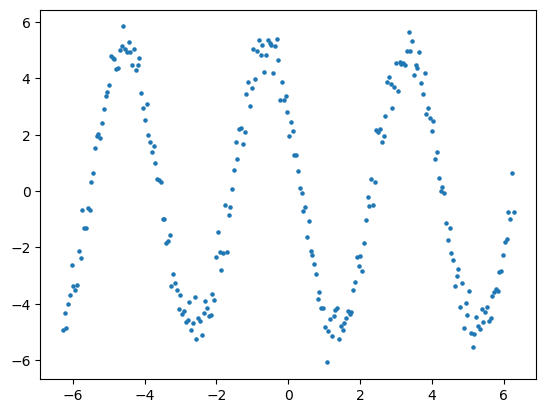

In [29]:
t = np.linspace(-2*np.pi, 2*np.pi, size)
A, B, C = np.random.uniform(0.5, 2*np.pi, size=3)
y = A*np.sin(B*t + C)
x = y + np.random.normal(0, std, size)

plt.scatter(t, x, s=5.0)
plt.show()

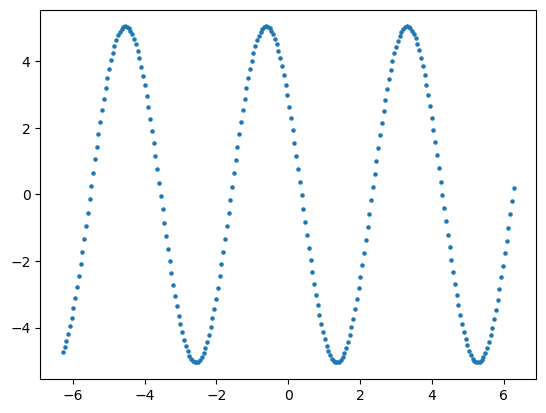

In [30]:
plt.scatter(t, y, s=5.0)
plt.show()

1/1 [==============================] - 0s 246ms/step


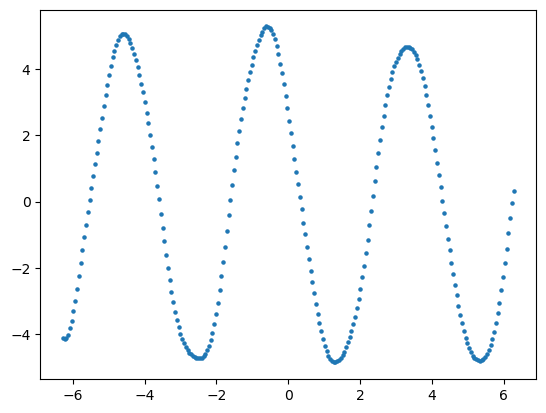

In [31]:
x_tensor = tf.reshape(tf.constant(x), (1, -1)) # to change the shape from (254,) to (1, 254)
# the first dimension is always the batch dimension even if there is only one data!

y_pred = model.predict(x_tensor)
plt.scatter(t, y_pred[0], s=5.0)
plt.show()

## Custom Training Loop

In [17]:
ds_train, ds_test = handson.mnist_TF(batch_size=32)

In [18]:
# simple sequential model
model = keras.Sequential([
    keras.Input((28, 28, 1)),
    keras.layers.Conv2D(32, 3, activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax"),])

In [19]:
num_epochs = 3
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
loss_metric = keras.metrics.SparseCategoricalCrossentropy(from_logits=False)
acc_metric = keras.metrics.SparseCategoricalAccuracy()

def update_acc(model, ds_test, acc):
    acc.reset_state() # to make sure acc is reset
    for x_batch, y_batch in ds_test:
        y_pred = model(x_batch, training=True)
        acc.update_state(y_batch, y_pred)

    return f"{acc.result().numpy():.3f}"

In [20]:
# tqdm module to wrap train data to show progress bar with custom inputs
num_batches = ds_train.cardinality().numpy()
custom_bar_format = "{desc}{bar} :{n_fmt}/{total_fmt} [ET={elapsed}{postfix}]"
fixed_width = 100 # size of the output (progress bar size will be adjusted accordingly)
z_num = len(str(num_epochs)) # for proper description text sizing

# training loop
for epoch in range(num_epochs):
    # train dataset iterable with progress bar
    train_iterator = tqdm(
        ds_train, 
        bar_format=custom_bar_format,
        ncols=fixed_width,
        total = num_batches,
        leave=True)

    # message before progress bar 
    epoch = str(epoch+1).zfill(z_num)
    train_iterator.set_description("Epoch [" + epoch + f"/{num_epochs}]")
    acc_test = "....."

    # batch training for loop
    for ind, (x_batch, y_batch) in enumerate(train_iterator):
        with tf.GradientTape() as tape:
            y_pred = model(x_batch, training=True)
            loss = loss_fn(y_batch, y_pred)

        # get gradients and optimize the loss with respect to weights
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # obtain loss and accuracy numerals to show after progress bar
        loss_metric.update_state(y_batch, y_pred)
        loss=mods.float2SI(loss_metric.result().numpy())
        acc_metric.update_state(y_batch, y_pred)
        acc=f"{acc_metric.result().numpy():.3f}"
        if ind+1 == num_batches: acc_test = update_acc(model, ds_test, acc_metric)

        # add loss, acc, and test accuracy script after progress bar
        train_iterator.set_postfix(loss=loss, acc=acc, test=acc_test)

    # end of epoch training: reset metrics for later epoch loops
    loss_metric.reset_state()
    acc_metric.reset_state()

acc_metric.reset_states() # alias of reset_state() for backward compatibility

Epoch [1/3]: █████████████████████████████ :1024/1024 [ET=00:18, acc=0.933, loss=237.6m, test=0.970]
Epoch [2/3]: █████████████████████████████ :1024/1024 [ET=00:15, acc=0.974, loss=089.8m, test=0.978]
Epoch [3/3]: █████████████████████████████ :1024/1024 [ET=00:15, acc=0.980, loss=068.6m, test=0.978]


In [22]:
for index, weight in enumerate(model.weights):
    print(gradients[index].shape)
    print(weight.shape)
    print(weight.name)
    print()

(3, 3, 1, 32)
(3, 3, 1, 32)
conv2d/kernel:0

(32,)
(32,)
conv2d/bias:0

(21632, 10)
(21632, 10)
dense/kernel:0

(10,)
(10,)
dense/bias:0



## Gradient Accumulation 

In [73]:
batch_size=32
ds_train, ds_test = handson.mnist_TF(batch_size=batch_size)

In [74]:
# simple sequential model
model = keras.Sequential([
    keras.Input((28, 28, 1)),
    keras.layers.Conv2D(32, 3, activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax"),])

In [79]:
num_epochs = 3
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
loss_metric = keras.metrics.SparseCategoricalCrossentropy(from_logits=False)
acc_metric = keras.metrics.SparseCategoricalAccuracy()

# optimizer has smaller learning rate since gradients will be combined
optimizer = keras.optimizers.Adam(learning_rate=0.001) 

def update_acc(model, ds_test, acc):
    acc.reset_state() # to make sure acc is reset
    for x_batch, y_batch in ds_test:
        y_pred = model(x_batch, training=True)
        acc.update_state(y_batch, y_pred)

    return f"{acc.result().numpy():.3f}"

def grad_shape_dtype(model):
    for weight in model.trainable_weights:
        yield weight.shape, weight.dtype

In [81]:
# training parameters
num_batches = ds_train.cardinality().numpy() # total number of batches per epoch
mini_batch_size = 4 # size of mini batch of epoch batches
custom_bar_format = "{desc}{bar} :{n_fmt}/{total_fmt} [ET={elapsed}{postfix}]"
fixed_width = 100 # size of the output (progress bar size will be adjusted accordingly)
z_num = len(str(num_epochs)) # for proper description text sizing

# zero gradients to initialize gradients for grad accumulation
grad_zeros = [tf.zeros(shape, dtype=dtype) for shape, dtype in grad_shape_dtype(model)]

# training loop
for epoch in range(num_epochs):
    # train dataset iterable with progress bar
    train_iterator = tqdm(
        ds_train, 
        bar_format=custom_bar_format,
        ncols=fixed_width,
        total = num_batches,
        leave=True)

    # message before progress bar 
    epoch = str(epoch+1).zfill(z_num)
    train_iterator.set_description("Epoch [" + epoch + f"/{num_epochs}]")
    acc_test = "....."

    # batch training for loop
    for ind, (x_batch, y_batch) in enumerate(train_iterator):
        # number of mini batches of epoch batch
        num_mini_batches = x_batch.shape[0] // mini_batch_size

        # reshape the dataset batch for inner mini batch for loop
        x_batch_reshaped = tf.reshape(x_batch, 
            (num_mini_batches, mini_batch_size, *x_batch.shape[1:]))
        y_batch_reshaped = tf.reshape(y_batch, 
            (num_mini_batches, mini_batch_size, *y_batch.shape[1:]))

        # initialize gradients to zero
        gradients = deepcopy(grad_zeros)
        
        # obtain gradients of mini batches for gradients accumulation
        for x_data, y_data in zip(x_batch_reshaped, y_batch_reshaped):
            with tf.GradientTape() as tape:
                y_pred = model(x_data, training=True)
                loss = loss_fn(y_data, y_pred)
    
            # get smaller gradients and add them to accumulated gradients
            mini_grads = tape.gradient(loss, model.trainable_weights)
            gradients = [g1 + g2 for g1, g2 in zip(gradients, mini_grads)]

        # optimize the weights from accumulated gradients
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # obtain loss and accuracy numerals to show after progress bar
        y_pred = model(x_batch)
        loss_metric.update_state(y_batch, y_pred)
        loss=mods.float2SI(loss_metric.result().numpy())
        acc_metric.update_state(y_batch, y_pred)
        acc=f"{acc_metric.result().numpy():.3f}"
        if ind+1 == num_batches: acc_test = update_acc(model, ds_test, acc_metric)

        # add loss, acc, and test accuracy script after progress bar
        train_iterator.set_postfix(loss=loss, acc=acc, test=acc_test)

    # end of epoch training: reset metrics for later epoch loops
    loss_metric.reset_state()
    acc_metric.reset_state()

acc_metric.reset_states() # alias of reset_state() for backward compatibility

Epoch [1/3]: █████████████████████████████ :1024/1024 [ET=01:03, acc=0.971, loss=106.4m, test=0.974]
Epoch [2/3]: █████████████████████████████ :1024/1024 [ET=01:03, acc=0.981, loss=068.8m, test=0.975]
Epoch [3/3]: █████████████████████████████ :1024/1024 [ET=01:03, acc=0.986, loss=051.6m, test=0.980]


In [82]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.evaluate(ds_test)

256/256 [==============================] - 1s 2ms/step - loss: 0.0645 - accuracy: 0.9805


[0.06453507393598557, 0.98046875]

## end